<a href="https://colab.research.google.com/github/SamusRam/ProFun/blob/main/TerpeneMiner_%2B_ColabFold_(input_sequence).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##TerpeneMiner
### with ColabFold v1.5.5 (AlphaFold2 using MMseqs2) for structure prediction


<img src="https://raw.githubusercontent.com/pluskal-lab/TerpeneMiner/refs/heads/main/data/readme_figures/fig_overview.png" height="300" align="center" style="height:240px">


[TerpeneMiner](https://github.com/pluskal-lab/TerpeneMiner/tree/main) is a state-of-the-art predictor of terpene synthase activity. This notebook leverages [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) for the prediction of the protein structure for consequent structural analysis by TerpeneMiner.

[Samusevich, R., Hebra, T. et al. Highly accurate discovery of terpene synthases powered by machine learning reveals functional terpene cyclization in Archaea. bioRxiv, 2024](https://doi.org/10.1101/2024.01.29.577750)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [1]:
#@title Install and load TerpeneMiner dependencies
import os
os.system('pip install py3Dmol')
os.system('pip install rdkit-pypi==2022.9.5')
import requests
from requests.exceptions import JSONDecodeError
from pathlib import Path
import py3Dmol
import matplotlib.pyplot as plt
from dataclasses import dataclass
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from rdkit import Chem
from IPython.display import display, HTML
import sys
from google.colab import output
import time

In [2]:
#@title Input protein sequence, then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MTRDWFNQICEEIKYQEKPIEISKNGHEPVSLRRLFKESFSCLVEERWIWDLYYRPLRMR EFWDESRAEKYFYATTFSVFILKYSYGSDISTTSTRHLHRHTVLTCYLDSIVDMGWLSWA KQFGMAVFGLIPDIPPFDPNQPVGFRSSIEEDFPRLRLLAEGPHKMEIMKSLLEAAAVEK TRDSATSFQDIARYRMESNLVCIRPFIPAMGDLLQPLAMMYSFFDDAMDVIEDVDAGQPS YLTNNEDIRRGGNIARAAMSELNSLSKVDWSWLAQAAILLSEVNAMLQISLSINEYNNIE NIGKHLFVRIAVLFFIILQ' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'viral' #@param {type:"string"}
# number of models to use
num_relax = 1 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname viral_2e0ed
sequence MTRDWFNQICEEIKYQEKPIEISKNGHEPVSLRRLFKESFSCLVEERWIWDLYYRPLRMREFWDESRAEKYFYATTFSVFILKYSYGSDISTTSTRHLHRHTVLTCYLDSIVDMGWLSWAKQFGMAVFGLIPDIPPFDPNQPVGFRSSIEEDFPRLRLLAEGPHKMEIMKSLLEAAAVEKTRDSATSFQDIARYRMESNLVCIRPFIPAMGDLLQPLAMMYSFFDDAMDVIEDVDAGQPSYLTNNEDIRRGGNIARAAMSELNSLSKVDWSWLAQAAILLSEVNAMLQISLSINEYNNIENIGKHLFVRIAVLFFIILQ
length 319


In [3]:
#@title Install ColabFold dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
installing conda...
installing amber...
CPU times: user 478 ms, sys: 72 ms, total: 550 ms
Wall time: 2min 22s


In [4]:
#@markdown ### ColabFold's MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [5]:
#@title ### Advanced Alphafold2 settings
model_type = "alphafold2_ptm"
num_recycles = "3" #@param ["0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "0.0" #@param ["0.0", "0.5", "1.0"]
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

save_all = False
save_recycles = False
save_to_google_drive = False
dpi = 200
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

In [6]:
#@title Run Alphafold2 Prediction
display_images = False #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)

2024-11-04 17:20:14,264 Running on GPU
2024-11-04 17:20:14,655 Found 6 citations for tools or databases
2024-11-04 17:20:14,656 Query 1/1: viral_2e0ed (length 319)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:03 remaining: 00:00]


2024-11-04 17:20:19,399 Setting max_seq=3, max_extra_seq=1
2024-11-04 17:20:54,995 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=33.1 pTM=0.225
2024-11-04 17:21:02,717 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=33.4 pTM=0.229 tol=9.97
2024-11-04 17:21:10,327 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=40.4 pTM=0.362 tol=5.19
2024-11-04 17:21:18,001 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=46.4 pTM=0.449 tol=2.88
2024-11-04 17:21:18,002 alphafold2_ptm_model_1_seed_000 took 46.5s (3 recycles)
2024-11-04 17:21:25,878 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=33 pTM=0.191
2024-11-04 17:21:33,691 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=33.4 pTM=0.211 tol=7.62
2024-11-04 17:21:41,606 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=34.9 pTM=0.22 tol=6.6
2024-11-04 17:21:49,485 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=35.5 pTM=0.258 tol=4.8
2024-11-04 17:21:49,486 alphafold2_ptm_model_2_seed_000 took 31.3s (3 recycles)
2024-11-04 17:21:57,600 alphafold2_p

In [7]:
#@title TerpeneMiner: Detect and analyze structural domains
import requests
import json
# The URL of the FastAPI endpoint
url = "http://147.231.128.68:9994/detect_domains/"

pdb_file_root = Path(f'{jobname}')
pdb_file = list(pdb_file_root.glob('*rank_001*.pdb'))[0]
is_bfactor_confidence_data = {'is_bfactor_confidence': 'true'}
if pdb_file.exists():
  with open(pdb_file, 'rb') as file_to_send:
      files = {'file': file_to_send}
      try:
        structural_predictions = requests.post(url, files=files, data=is_bfactor_confidence_data).json()
      except JSONDecodeError:
        structural_predictions = None

In [8]:
#@title Getting comparisons to the known domains
url = "http://147.231.128.68:9994/download_pdb/"

if structural_predictions['aligned_pdb_filepaths'] is not None:
  for module_id, alignment_details in structural_predictions['aligned_pdb_filepaths'].items():
    aligned_pdb_filename = alignment_details['aligned_pdb_name']
    response = requests.get(f"{url}{aligned_pdb_filename}")

    with open(f"{aligned_pdb_filename}.pdb", "wb") as f:
        f.write(response.content)
else:
  print("No TPS domains were detected!")

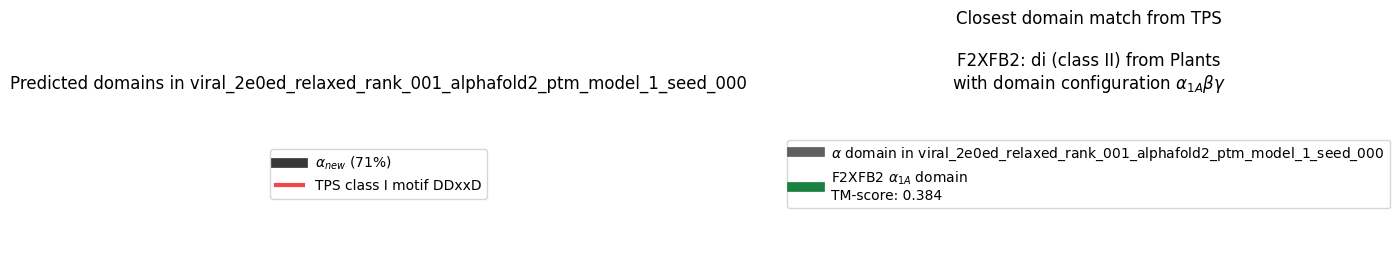

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
#@title Display predicted domains with comparisons to the closest known domains


def compress_selection_list(selected_residues: list[int]) -> str:
    """
    Compresses a list of selected residues into a concise string representation.

    :param selected_residues: A list of residue numbers to be compressed

    :return: A string representing the compressed form of the residue list, with consecutive residues represented
             as ranges (e.g., "1-3+5+7-10")
    """
    sorted_residues = sorted(map(int, selected_residues))
    start_res = None
    intervals = []
    for res in sorted_residues:
        if start_res is None:
            start_res = res
        else:
            if prev_res + 1 != res:
                if start_res == prev_res:
                    intervals.append(f"{start_res}")
                else:
                    intervals.append(f"{start_res}-{prev_res}")
                start_res = res
        prev_res = res

    if start_res is not None:
        if start_res == prev_res:
            intervals.append(f"{start_res}")
        else:
            intervals.append(f"{start_res}-{prev_res}")
    return intervals

def show_domains(structural_predictions, pdb_file):
    protein_id = ''.join(re.sub(r'\(.*?\)', '', pdb_file.stem).split())
    regions = structural_predictions['domains'][protein_id]
    colors_map = {}
    domain_names_with_colors = []
    type_2_display_name = {
        'alpha1A': '$\\alpha_{1A}$',
        'alpha1B': '$\\alpha_{1B}$',
        'alpha2A': '$\\alpha_{2A}$',
        'alpha2B': '$\\alpha_{2B}$',
        'alpha2C': '$\\alpha_{2C}$',
        'alpha2D': '$\\alpha_{2D}$',
        'alpha2E': '$\\alpha_{2E}$',
        'alpha2F': '$\\alpha_{2F}$',
        'alpha3A': '$\\alpha_{3A}$',
        'alpha3B': '$\\alpha_{3B}$',
        'alpha4A': '$\\alpha_{4A}$',
        'alpha4B': '$\\alpha_{4B}$',
        'alpha4C': '$\\alpha_{4C}$',
        'beta': '$\\beta$',
        'delta1': '$\\delta_1$',
        'delta2': '$\\delta_2$',
        'epsilon': '$\\epsilon$',
        'gamma': '$\\gamma$'
    }

    colors = {
        "$\\alpha_{1A}$": "#1A8140",
        "$\\alpha_{1B}$": "#1A8140",
        "$\\alpha_{2A}$": "#B11F6F",
        "$\\alpha_{2B}$": "#B11F6F",
        "$\\alpha_{2C}$": "#B11F6F",
        "$\\alpha_{2D}$": "#B11F6F",
        "$\\alpha_{2E}$": "#B11F6F",
        "$\\alpha_{2F}$": "#B11F6F",
        "$\\alpha_{3A}$": "#954921",
        "$\\alpha_{3B}$": "#954921",
        "$\\alpha_{4A}$": "#606161",
        "$\\alpha_{4B}$": "#606161",
        "$\\alpha_{4C}$": "#606161",
        "$\\beta$": "#DCC225",
        "$\\gamma$": "#554C9F",
        "$\\delta_1$": "#4068B1",
        "$\\delta_2$": "#283989",
        "$\\epsilon$": "#FFC0CB",
        "$\\alpha_{new}": "#3A3737",
        "$\\beta_{new}": "#3A3737",
        "$\\gamma_{new}": "#3A3737",
        "$\\delta_{new}": "#3A3737",
        "$\\epsilon_{new}": "#3A3737"
    }
    motif_colors = {"DDxxD": "#F04848", "NSE/DTE": "#E990BD", "DxDD": "#5D9BD3"}

    for region_ in regions:
        mapped_residues = set(region_['residues_mapping'].keys())
        module_id = region_['module_id']
        pred_domain_type, confidence = max(structural_predictions['domain_type_predictions'][module_id].items(), key=lambda x: x[1])
        if region_['domain'] == 'alphaWeird':
            region_['domain'] = 'alpha'
            pred_domain_type, confidence = 'novel', 0.99
        if pred_domain_type in type_2_display_name:
            domain_name_current = type_2_display_name[pred_domain_type]
        else:
            assert pred_domain_type == 'novel'
            domain_name_current = f"$\\{region_['domain']}" + "_{new}$"
        color = colors.get(domain_name_current, "#3A3737")
        domain_names_with_colors.append([f"{domain_name_current} ({100*confidence:.0f}%)", color])
        for res in mapped_residues:
            colors_map[res] = color
    for sequence_motif in structural_predictions['motif_detections']:
       for res in range(sequence_motif['start'], sequence_motif['end']):
          colors_map[res] = motif_colors[sequence_motif['motif']]
    with open(pdb_file, "r") as file:
        af2_struct = file.read()

    max_window_width_retries = 5
    window_width = 0
    width_retrieval_attempt = 0
    while window_width == 0 and width_retrieval_attempt < max_window_width_retries:
      window_width = output.eval_js('window.innerWidth')
      time.sleep(0.1)
      width_retrieval_attempt += 1
    if window_width == 0:
      window_width = 900
    window_width = min(700*(len(regions) + 1), window_width)

    per_region_width = window_width // (len(regions) + 1)
    view = py3Dmol.view(js="https://3dmol.org/build/3Dmol.js", width=per_region_width * (1 + len(regions)), height=per_region_width, viewergrid=(1, 1 + len(regions)), linked=True)
    view.addModel(af2_struct, "pdb",viewer=(0,0))
    view.setStyle({'cartoon': {'thickness': 0.1, 'width': 0.2}}, viewer=(0,0))
    for interval in compress_selection_list(structural_predictions['secondary_structure_residues']):
      view.setStyle({'resi': interval}, {'cartoon': {'thickness': 1.5, 'width': 2.0, "colorscheme": {"prop": "resi", "map": colors_map}}}, viewer=(0,0))
    view.zoomTo(viewer=(0, 0))

    similar_domains = []
    for domain_i, region_ in enumerate(regions):
        module_id = region_['module_id']
        similar_domain = structural_predictions['aligned_pdb_filepaths'][module_id]
        aligned_pdb_name = f"{similar_domain['aligned_pdb_name']}.pdb"
        with open(aligned_pdb_name, "r") as file:
            aligned_struct = file.read()
        view.addModel(aligned_struct, 'pdb', viewer=(0,domain_i + 1))
        domain_name_closest = type_2_display_name.get(similar_domain['closest_domain_type'], similar_domain['closest_domain_type'])
        color = colors.get(domain_name_closest, "#3A3737")
        pred_domain_type, confidence = max(structural_predictions['domain_type_predictions'][module_id].items(), key=lambda x: x[1])

        view.setStyle({'chain': 'A'}, {'cartoon': {'color': color}}, viewer=(0, domain_i + 1))
        view.setStyle({'chain': 'B'}, {'cartoon': {'color': colors.get(type_2_display_name.get(pred_domain_type, ""), "#3A3737"), 'opacity': 0.8}}, viewer=(0, domain_i + 1))
        view.zoomTo(viewer=(0, domain_i + 1))
        similar_domains.append((pred_domain_type if pred_domain_type != 'novel' else region_['domain'], color, similar_domain))


    # legend
    px = 1/plt.rcParams['figure.dpi']
    fig, ax = plt.subplots(1, 1 + len(regions), figsize=(1.2*window_width*px, 2))
    for domain, color in domain_names_with_colors:
        ax[0].plot([], [], color=color, label=domain, linewidth=7)
    for sequence_motif in structural_predictions['motif_detections']:
        class_tps = sequence_motif['class_tps']
        ax[0].plot([], [], color=motif_colors[sequence_motif['motif']], label=f"TPS {class_tps} motif {sequence_motif['motif']}", linewidth=3)
    ax[0].legend(loc="center", ncol=1)
    ax[0].set_title(f"Predicted domains in {protein_id}")
    ax[0].axis("off")

    for closest_domain_i, (detected_domain_type, similar_domain_color_type, similar_domain_dict) in enumerate(similar_domains):
        ax[closest_domain_i + 1].plot([], [], color="#3A3737", label=f"$\\{detected_domain_type}$ domain in {protein_id}", linewidth=7, alpha=0.8)
        domain_name_closest = type_2_display_name.get(similar_domain_dict['closest_domain_type'], similar_domain_dict['closest_domain_type'])
        ax[closest_domain_i + 1].plot([], [], color=similar_domain_color_type, label=f"{similar_domain_dict['closest_known_domain_pdb_id']} {domain_name_closest} domain\nTM-score: {similar_domain_dict['tm_score']:.3f}", linewidth=7)
        ax[closest_domain_i + 1].legend(loc="center", ncol=1)
        whole_domain_config = [type_2_display_name.get(dom_type, dom_type) for dom_type in similar_domain_dict['whole_structure_domain_config']]
        ax[closest_domain_i + 1].set_title(f"Closest domain match from TPS\n\n{similar_domain_dict['closest_known_domain_pdb_id']}: {'|'.join(similar_domain_dict['closest_id_reaction_types'])} from {similar_domain_dict['closest_id_kingdom']}\nwith domain configuration {''.join(whole_domain_config)}")
        ax[closest_domain_i + 1].axis("off")
    plt.show()

    return view

if pdb_file.exists() and structural_predictions['aligned_pdb_filepaths'] is not None and structural_predictions['domain_type_predictions']:
  display(show_domains(structural_predictions, pdb_file))
else:
  print("No TPS domains were detected!")

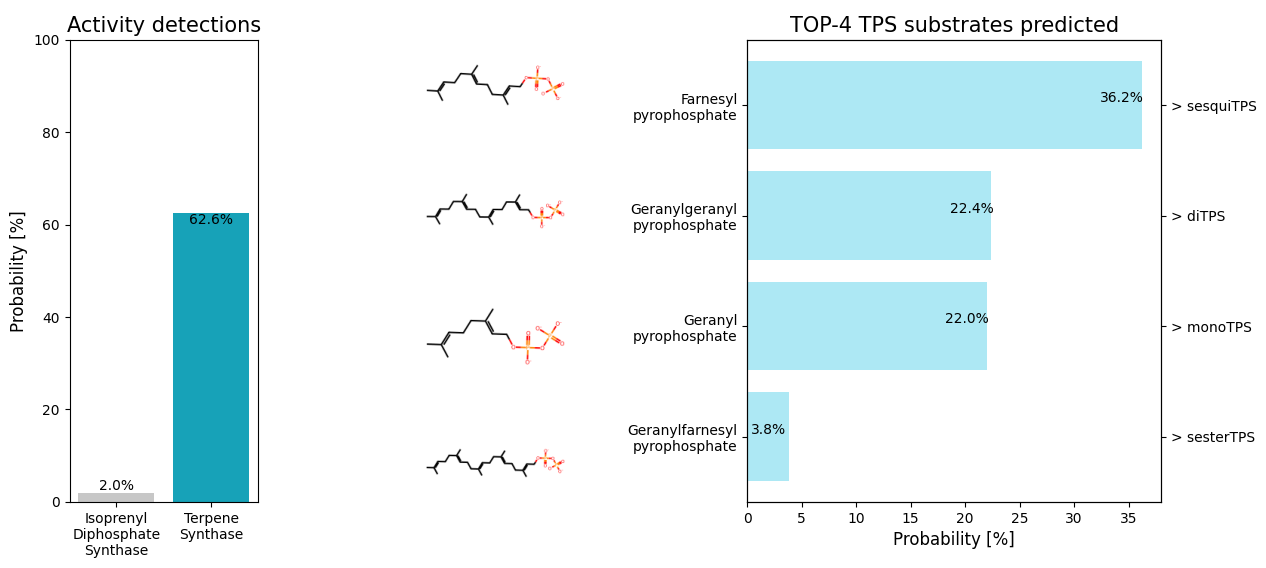

In [12]:
#@title Get TPS activity predictions
url = "http://147.231.128.68:9994/predict_tps/"

is_bfactor_confidence_data = {'is_bfactor_confidence': 'true'}
if pdb_file.exists():
    with open(pdb_file, 'rb') as file_to_send:
        files = {'file': file_to_send}
        try:
          substr_predictions = requests.post(url, files=files, data=is_bfactor_confidence_data).json()
        except JSONDecodeError:
          print("No predictions")
          substr_predictions = None

    if substr_predictions is not None:
        fig = plt.figure(figsize=(17, 6))
        gs = gridspec.GridSpec(1, 6)  # 2 rows, 3 columns grid

        detection_probs = [substr_predictions['predictions'][0][key]*100 for key in ['precursor substr', 'isTPS']]


        ax1 = fig.add_subplot(gs[0, 0])
        if detection_probs[1] > 30:
            ax2 = fig.add_subplot(gs[0, 3:5])
        ax1.bar(['Isoprenyl\nDiphosphate\nSynthase', 'Terpene\nSynthase'], detection_probs, color=['#c7c7c7', '#17A2B8'])
        ax1.set_ylim((0, 100))
        ax1.set_title('Activity detections', fontsize=15)
        ax1.set_ylabel('Probability [%]', fontsize=12)
        for i, value in enumerate(detection_probs):
            ax1.text(i, max(2, value - max(detection_probs)*0.05), f"{value:.1f}%", ha='center', va='bottom')

        if detection_probs[1] > 30:
            substrate_predictions = [(subst, pred) for subst, pred in substr_predictions['predictions'][0].items() if subst not in {'precursor substr', 'isTPS'}]
            substrate_predictions_top = sorted(substrate_predictions, key=lambda x: x[1])[-4:]

            substr_2_type = {"CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "sesquiTPS",
                            "CC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "monoTPS",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O":  "diTPS",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC1OC1(C)C": "triTPS (class II)",
                            "CC1(C)CCCC2(C)C1CCC(=C)C2CCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "diTPS",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "sesterTPS",
                            "CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O.CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O":  "triTPS (squalene synthase)",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O.CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "tetraTPS"}
            substr_2_name = {"CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "Farnesyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "Geranyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O":  "Geranylgeranyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC1OC1(C)C": "(S)-2,3-epoxysqualene",
                            "CC1(C)CCCC2(C)C1CCC(=C)C2CCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "copalyl diphosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "Geranylfarnesyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O.CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O":  "2x Farnesyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O.CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "2x Geranylgeranyl\npyrophosphate"}

            for smiles_i, (smiles, _) in enumerate(substrate_predictions_top):
                mol = Chem.MolFromSmiles(smiles)
                im = Chem.Draw.MolToImage(mol, size=(200, 200))
                ax_ = plt.axes([0.25, 0.21*smiles_i + 0.05, 0.25, 0.25], frameon=True)
                ax_.imshow(im)
                ax_.axis('off')

            probabilities = [100*prob for _, prob in substrate_predictions_top]
            max_prob = max(probabilities)
            ax2.barh([substr_2_name[smiles] for smiles, _ in substrate_predictions_top], probabilities, color='#ADE8F4')
            for i, value in enumerate(probabilities):
                ax2.text(max(1, value - max_prob*0.05), i, f"{value:.1f}%", ha='center', va='bottom')
            if max_prob == 0:
                ax2.set_xlim((0, 5))

            ax2_secondary_ylabels = ax2.twinx()
            ax2_secondary_ylabels.set_ylim(ax2.get_ylim())
            ax2_secondary_ylabels.set_yticks(ax2.get_yticks())
            ax2_secondary_ylabels.set_yticklabels([f'> {substr_2_type[smiles]}' for smiles, _ in substrate_predictions_top])

            ax2.set_title('TOP-4 TPS substrates predicted', fontsize=15)
            _ = ax2.set_xlabel('Probability [%]', fontsize=12)